In [124]:
import pandas as pd
from tqdm import tqdm
import os
from scipy.stats import norm

In [125]:
# Seed value
# Apparently you may use different seed values at each stage
seed_value= 42

# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set the `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

# # 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

from tqdm.notebook import tqdm
tf.random.set_seed(seed_value)
import multiprocessing


In [126]:
import matplotlib.pyplot as plt

import pickle

In [127]:
alogp_bottleneck = np.load("..//Data/small_mol_phase_3_features_for_psa.npy")

In [128]:
# ## read in all the drug features
# ## for train test and valid
train_drugs = alogp_bottleneck[:, :32]

In [129]:
# ## read in all the omics features
# ## for train test and valid
train_omics = alogp_bottleneck[:, 32:]

In [130]:
def ann(hidden = 10): 
    input_layer = tf.keras.layers.Input(shape = (X_train_word2vec.shape[1]))
    hidden_layer = tf.keras.layers.Dense(hidden)
    hidden_output = hidden_layer(input_layer)
    pred_layer = tf.keras.layers.Dense(1)
    pred_output = pred_layer(hidden_output)
#     pred_output = tf.keras.layers.Activation("softmax")(pred_output)
    model = tf.keras.models.Model(input_layer, pred_output)
    return model

In [131]:
X_train_word2vec = train_omics

In [132]:
h1, h2 = 16,16

In [133]:
ann_15 = ann(h1)

In [134]:
ann_15.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 32)]              0         
                                                                 
 dense_8 (Dense)             (None, 16)                528       
                                                                 
 dense_9 (Dense)             (None, 1)                 17        
                                                                 
Total params: 545
Trainable params: 545
Non-trainable params: 0
_________________________________________________________________


In [135]:
X_train_word2vec = train_drugs

In [136]:
ann_20 = ann(h2)

In [137]:
total_weights_1 = ann_15.count_params()

In [138]:
total_weights_2 = ann_20.count_params()

In [139]:
total_weights = total_weights_1 + total_weights_2 + 1 

In [140]:
total_weights

1091

In [141]:
# batch size
# batch_size = 256

In [142]:
from scipy.stats import multivariate_normal as mvn

In [143]:
from scipy.stats import invgamma, norm

In [144]:
from tqdm.notebook import tqdm

In [145]:
threshold = 5

In [146]:
import random

In [147]:
lr = 0.1

In [148]:
import numpy as np

In [149]:
weights_ann_1 = ann_15.get_weights()
weights_ann_2 = ann_20.get_weights()

In [150]:
def get_targets_with_weights(batch_data, batch_data1, initial_ensembles, log_sigma_points_1): 

    n_hidden_1 = len(weights_ann_1[0].ravel())

    hidden_weights_1 = initial_ensembles[:,:n_hidden_1].reshape( size_ens, batch_data.shape[1], h1)

    
    hidden_output_1 = np.einsum('ij,kjl->kil', batch_data, hidden_weights_1)

    
    hidden_layer_bias_1 = initial_ensembles[:,n_hidden_1:(n_hidden_1 + h1)].reshape(size_ens, 1,  h1)



    hidden_output_1 = hidden_output_1 + hidden_layer_bias_1

    n_pred_weights_1 = len(weights_ann_1[2].ravel())

    output_weights_1 = initial_ensembles[:,(n_hidden_1 + h1):(n_hidden_1 + h1 + n_pred_weights_1) ].reshape(size_ens, h1, 1)

    output_1 = np.einsum('ijk,ikl->ijl', hidden_output_1, output_weights_1)


    output_layer_bias_1 = initial_ensembles[:,(n_hidden_1 + h1 + n_pred_weights_1):(n_hidden_1 + h1 + n_pred_weights_1 + 1)].reshape(size_ens, 1, 1)



    final_output_1 = output_1 + output_layer_bias_1

    n_hidden_2 = len(weights_ann_2[0].ravel())

    initial_ensembles_1 = initial_ensembles.copy()[:, total_weights_1:(total_weights_1+ total_weights_2)]

    hidden_weights_2 = initial_ensembles_1[:,:n_hidden_2].reshape(size_ens, batch_data1.shape[1], h2)



    hidden_output_2 = np.einsum('ij,kjl->kil', batch_data1, hidden_weights_2)

    hidden_layer_bias_2 = initial_ensembles[:,n_hidden_2:(n_hidden_2 + h2)].reshape(size_ens, 1,  h2)

    hidden_output_2 = hidden_output_2+ hidden_layer_bias_2

    n_pred_weights_2 = len(weights_ann_2[2].ravel())

    output_weights_2 = initial_ensembles_1[:,(n_hidden_2 + h2):(n_hidden_2 + h2 + n_pred_weights_2) ].reshape(size_ens, h2, 1)


    output_2 = np.einsum('ijk,ikl->ijl', hidden_output_2, output_weights_2)


    output_layer_bias_2 = initial_ensembles_1[:,(n_hidden_2 + h2 + n_pred_weights_2):(n_hidden_2 + h2 + n_pred_weights_2 + 1)].reshape(size_ens, 1, 1)


    final_output_2 = output_2 + output_layer_bias_2


    weights_1 = initial_ensembles[:, :total_weights_1]

    weights_2 = initial_ensembles[:, total_weights_1:(total_weights_1 + total_weights_2)]


    avg_weights = initial_ensembles[:, -1].reshape(-1,1)

    avg_weights_sig = expit(avg_weights)
    
    avg_weights_sig = avg_weights_sig.reshape(avg_weights_sig.shape[0], 1, avg_weights_sig.shape[1])
    
    complement_weights_sig = 1 - expit(avg_weights)
    
    complement_weights_sig = complement_weights_sig.reshape(complement_weights_sig.shape[0], 1, complement_weights_sig.shape[1])

    final_output_1 = final_output_1*complement_weights_sig
    
    final_output_2 = final_output_2*avg_weights_sig
    
    output_1_ravel = final_output_1.reshape(size_ens, final_output_1.shape[1]*final_output_1.shape[2])

    output_2_ravel = final_output_2.reshape(size_ens, final_output_2.shape[1]*final_output_2.shape[2])


    output_1_ravel = output_1_ravel

    output_2_ravel = output_2_ravel



    weights_1_add = np.zeros((size_ens, (total_weights_2 - total_weights_1)))



    weights_1 = np.hstack((weights_1, weights_1_add))
    


    stack_1 = np.hstack((output_1_ravel, weights_1, np.repeat(0, size_ens).reshape(-1,1), np.repeat(0, size_ens).reshape(-1,1)))



    
    stack_2 = np.hstack((output_2_ravel, weights_2, avg_weights, log_sigma_points_1))

    
    initial_aug_state = np.hstack((stack_1, stack_2)) 
    

    return initial_aug_state , output_1_ravel, output_2_ravel, log_sigma_points_1



In [151]:
import time

In [152]:
from scipy.stats import multivariate_normal as mvn

In [153]:
var_weights =1

In [154]:
from scipy.stats import multivariate_normal as mvn

In [155]:
reduction = 4

In [156]:
shape_needed = total_weights//reduction

In [157]:
size_ens = shape_needed

In [158]:
size_ens = int(size_ens)

In [159]:
size_ens

272

In [160]:
import matplotlib.pyplot as plt

In [161]:
from scipy.special import expit

In [162]:
from datetime import datetime

In [163]:
def expit(x):
    """Compute softmax values for each sets of scores in x."""
#     e_x = np.exp(x - np.max(x))
    return 1 / (1 + np.exp(-x))

In [164]:
from scipy.stats import gamma

In [165]:
from datetime import datetime

In [166]:
from sklearn.metrics import mean_squared_error

In [167]:
import random

In [168]:
y_valid = pd.read_csv("..//Data/smiles_with_rdkit_with_small_phase_3_outputs.csv")
y_valid_psa = y_valid.iloc[:,2].values.reshape(-1,1)

In [169]:
std_targets = pickle.load(open('..//Data//psa_target_scaler.pkl', 'rb'))

/home/statgrads/vpiyush2/.conda/envs/enkf/lib/python3.11/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator StandardScaler from version 1.1.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [170]:
y_train = std_targets.transform(y_valid_psa)

In [171]:
y_train.var()

1.579356024681393

In [172]:
gamma_param = int(y_train.var()*100)

In [173]:
gamma_param = int(1*100)

In [174]:
gamma_param

100

In [175]:
y_train.reshape(-1,1).shape

(959, 1)

In [176]:
from tqdm.notebook import tqdm

In [177]:
train_omics.shape

(959, 32)

In [182]:
train_drugs.shape

(959, 32)

In [183]:
def rep_one_real_world(idx, inflation_factor = 0.5, cutoff = 100): 
    catch_1 = []
    catch_2 = []
    catch_3 = []
    catch_4 = []
    catch_5 = []
#     from scipy.special import expit
    patience_smaller = 0
    patience_uns = 0

    
    best_train_width = 100000
    

    X_train_logits = y_train.reshape(-1,1)

    
    ## create training batch chunks
    train_idx = list(range(0, X_train_logits.shape[0]))
    batch_chunks = [train_idx[i:i+batch_size] for i in range(0,len(train_idx),batch_size)]

    ## generate some augmented variable for iteration 0
    initial_aug_state_mean = np.repeat(0, total_weights)
    initial_aug_state_mean = initial_aug_state_mean.reshape(-1,1)

    initial_aug_state_cov = var_weights*np.identity((total_weights))
    initial_ensembles = mvn(initial_aug_state_mean.reshape(initial_aug_state_mean.shape[0],), initial_aug_state_cov).rvs(size = size_ens)

    exit_iter_no_thresh = 0
    log_sigma_points_1 = (np.log(gamma(gamma_param, scale = 1/100).rvs(size_ens))).reshape(size_ens, 1)

    train_lstm = train_omics
    
    train_doc2vec = train_drugs
    
    
    # train_doc2vec = train_omics

    train_valid_lstm = train_lstm
    train_valid_doc2vec = train_doc2vec

    
    best_coverage_train = 0
    
    start = datetime.now()
    
    for iter1 in tqdm(range(0,500)):
        random_idx = random.sample(range(train_valid_lstm.shape[0]), train_valid_lstm.shape[0])
        train_valid_lstm =train_valid_lstm[random_idx, :]
        train_valid_doc2vec = train_valid_doc2vec[random_idx, :]
        X_train_logits = X_train_logits[random_idx, :]
        
        for batch_idx in (batch_chunks):

            batch_data = train_valid_lstm[batch_idx,:]
            batch_data1 = train_valid_doc2vec[batch_idx,:]
            # print(batch_data.shape)
            batch_targets = X_train_logits[batch_idx,:]
            

            column_mod_2_shape = total_weights_2 + batch_data.shape[0]*1 + 1 + 1
        
            H_t = np.hstack((np.identity(batch_targets.shape[0]), np.zeros((batch_targets.shape[0], column_mod_2_shape-batch_targets.shape[0]))))

            current_aug_state, column_mod_1, column_mod_2, log_sigma_points_1 = get_targets_with_weights(batch_data, batch_data1, initial_ensembles, log_sigma_points_1)
            
            # print(current_aug_state.shape)
            
            # var_targets_vec = np.exp(log_sigma_points_1)
            var_targets_vec = np.log(1 + np.exp(log_sigma_points_1))
            
            var_targets_vec = var_targets_vec
            
            # current_aug_state_var = np.cov(current_aug_state.T) + inflation_factor*np.identity(current_aug_state.shape[1])
            
            current_aug_state_var = np.cov(current_aug_state.T) 
            
            G_t = np.array([1 , 1]).reshape(-1,1)
            
            scirpt_H_t = np.kron(G_t.T, H_t)
            
            temp1 = current_aug_state_var@scirpt_H_t.T
            
            temp2 = scirpt_H_t@current_aug_state_var@scirpt_H_t.T
        
            for ensemble_idx in range(0, current_aug_state.shape[0]):
                
                var_targets1 = var_targets_vec[ensemble_idx,:]
                
                R_t = var_targets1*np.identity(batch_targets.shape[0])
            
                measurement_error = mvn(np.repeat(0,batch_targets.shape[0]), var_targets1*np.identity(batch_targets.shape[0])).rvs(1).reshape(-1,1)
            
                target_current = batch_targets + measurement_error
                
                # print(target_current.shape)
                
                K_t = temp1@np.linalg.pinv(temp2 + R_t)
                
                # print(K_t.shape)

                current_aug_state[ensemble_idx,:] = current_aug_state[ensemble_idx,:] +(K_t@(target_current -scirpt_H_t@current_aug_state[ensemble_idx,:].reshape(-1,1))).reshape(current_aug_state.shape[1],)
        

            weights_ann_1 = current_aug_state[:,batch_targets.shape[0]:(batch_targets.shape[0] + total_weights_1)]      

            weights_ann_2 = current_aug_state[:,-(total_weights_2+1):-2]    

            initial_ensembles = np.hstack((weights_ann_1, weights_ann_2, current_aug_state[:,-2].reshape(-1,1)))
            
            log_sigma_points_1 = current_aug_state[:,-1].reshape(-1,1)
               
            avg_betas = expit(current_aug_state[:,-2])
        
            complement = 1-avg_betas

            
            
            
            
            current_aug_state1, column_mod_11, column_mod_21, log_sigma_points_1 = get_targets_with_weights(train_lstm, train_doc2vec, initial_ensembles, log_sigma_points_1)
            
            initial_targets = column_mod_11 + column_mod_21
            
            
            initial_targets = initial_targets.reshape(size_ens, train_lstm.shape[0],1)
            
            initial_targets_train = initial_targets
            
            
            
            
#             ind = (X_train_logits_true >= np.percentile(initial_targets_train, axis = 0, q = (2.5, 97.5))[0,:,:]) & (X_train_logits_true <= np.percentile(initial_targets_train, axis = 0, q = (2.5, 97.5))[1,:,:])
        
            # initial_targets_softmax = expit(initial_targets)
        
            # initial_softmax_train = initial_targets_softmax
            
            initial_targets_train_mean = initial_targets_train.mean(0)
            
            # print(initial_targets_train_mean.shape)
            
            li = np.percentile(initial_targets_train, axis = 0, q = (2.5, 97.5))[0,:,:]
            
            ui = np.percentile(initial_targets_train, axis = 0, q = (2.5, 97.5))[1,:,:]
            
            width = ui - li
            
            avg_width_train = np.mean(width)
            
            # interim = np.vstack((catch_train_probs[idx] , catch_valid_probs[idx] ))
        
            interim = (X_train_logits)
            
            # print(interim.shape)
            
            ind = (interim >= li) & (interim <= ui)
            
            coverage_train= np.mean(ind.ravel())  
            
            train_mae = np.sqrt(mean_squared_error(interim, initial_targets_train_mean))
            
            print(train_mae, coverage_train, avg_width_train)
        
        plt.scatter(interim, initial_targets_train_mean)
        plt.show()

In [184]:
batch_size = 32

  0%|          | 0/500 [00:00<?, ?it/s]

2.687967849410565 1.0 48.579684959132166
1.9513325820428784 1.0 46.240184787419636
2.2000791707547926 1.0 47.35418304117622
1.8708005691176002 1.0 45.9152776157245
2.2445256950799544 1.0 46.41025757571402
2.2039089678232746 1.0 46.343607655298484
2.260959654269361 1.0 45.82157003824649
2.181348232216248 1.0 46.03960073673169
2.1372570768031234 1.0 46.12678335580596
2.1220225157541575 1.0 45.780502574373095
1.984529344040201 1.0 45.71329003906498
2.018064206608528 1.0 45.620135170876374
2.1785255576291553 1.0 45.78906670869291
2.26719549587247 1.0 44.89649042232792
2.1110147625331717 1.0 44.81514930888703
2.204027337477789 1.0 44.40252256344909
2.0781151650227567 1.0 44.78692555967546
2.0409770284522004 1.0 44.40492842161355
1.9628443417271821 1.0 44.69743374856564
1.9395948517886192 1.0 44.52733956749092
1.9327621635102867 1.0 44.91253363163905
1.9831451753265061 1.0 44.35940942803201
2.168264429322067 1.0 44.41698526735736
2.0647458830698313 0.9989572471324296 44.05865771658039
2.0929

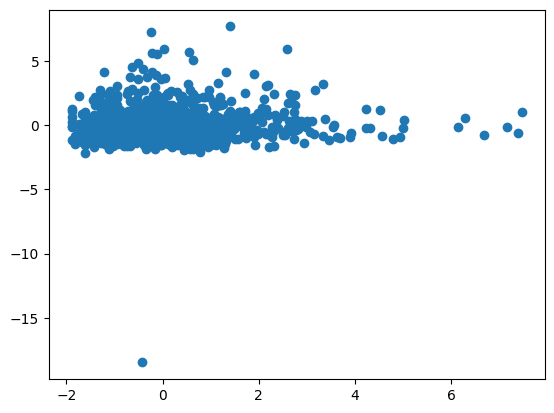

1.8949405181272234 1.0 44.58741127801627
1.851867805252935 1.0 44.46660831365302
1.8772600095176912 0.9989572471324296 44.329648387288046
1.9441821558411378 0.9989572471324296 44.09507911623648
1.9709539523962496 1.0 44.60396581811265
2.1102048871120025 1.0 44.66281289066841
2.118513839680652 1.0 44.807180735216114
2.041844815645286 1.0 44.930250944069265
2.0718967405964017 1.0 45.22568242458855
2.1225633161497646 1.0 45.21404339984867
2.1095147828674077 1.0 45.028997593364586
2.09580237626122 1.0 44.99106345290565
2.068056367145147 1.0 44.67630927144373
2.062411404071922 1.0 44.66639074181786
2.0338448612017825 1.0 44.70754425328709
2.039027899214577 1.0 44.426722272507895
2.059958359495968 1.0 44.61932569184852
2.1784994297123723 0.9989572471324296 45.611114641257124
2.2447219056574936 1.0 45.65443945158948
2.272276846440111 1.0 45.70533381182817
2.3605177814528044 1.0 45.64339255579133
2.2683598937387623 1.0 45.80437163442703
2.281820250511402 1.0 45.682315971350995
2.30958105656467

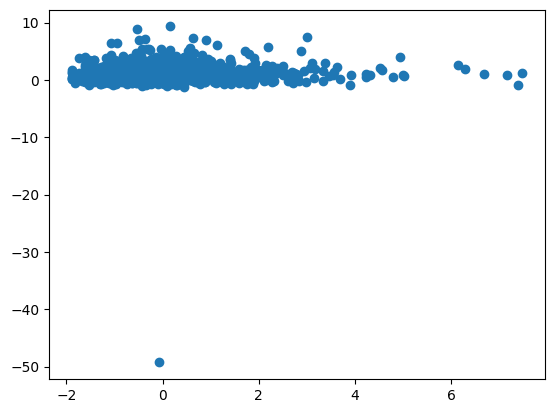

2.380654255633588 1.0 45.69189197680407
2.754861521661516 1.0 43.783884835358236
2.448252039541831 1.0 45.06383225535381
2.5161621569620625 1.0 43.24710793354292
2.3395372093646176 0.9989572471324296 43.703009095190815
2.394182600596508 1.0 43.01284612413595
2.390428051980017 1.0 43.135173886341526
2.4931690576182266 1.0 43.110728195464354
2.490702889749391 0.9989572471324296 43.54453253525875


KeyboardInterrupt: 

In [185]:
rep_one_real_world(1)